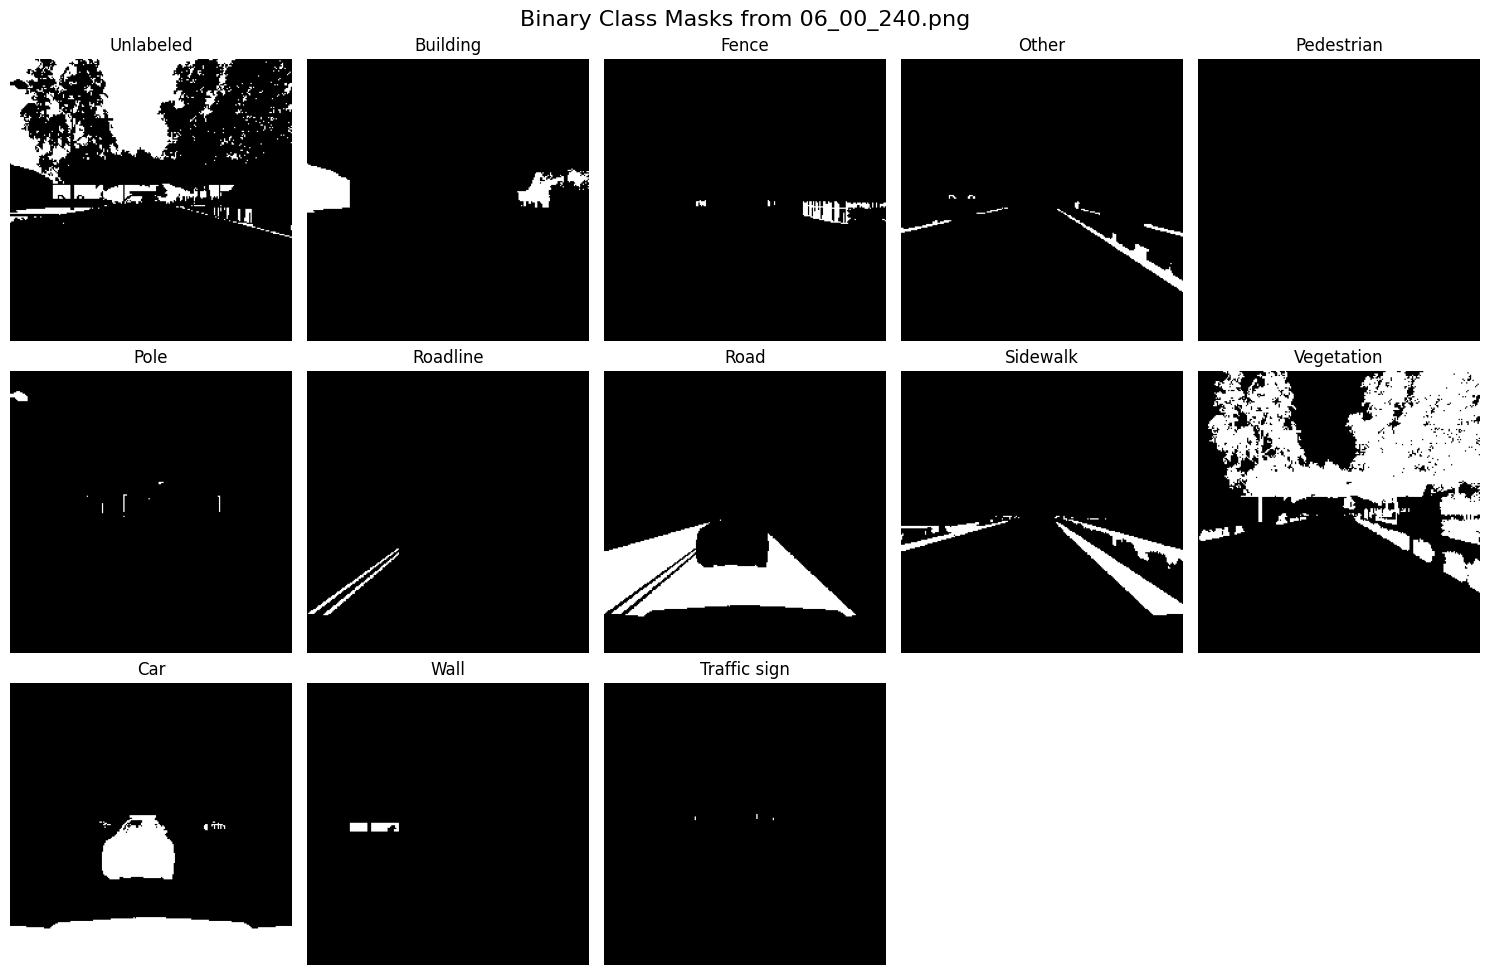

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

# Define class names (IDs: 0 to 12)
CLASS_NAMES = [
    "Unlabeled", "Building", "Fence", "Other", "Pedestrian", "Pole",
    "Roadline", "Road", "Sidewalk", "Vegetation", "Car", "Wall", "Traffic sign"
]

def visualize_sample_masks(base_path, folder='train'):
    """
    Visualizes binary masks for each class from a random mask file in the dataset.

    Args:
        base_path (str): Root path to the dataset.
        folder (str): Folder name: 'train' or 'test'.
    """
    mask_dir = os.path.join(base_path, folder, 'labels')
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]
    
    sample_mask_path = os.path.join(mask_dir, random.choice(mask_files))
    mask = np.array(Image.open(sample_mask_path))

    if mask.ndim == 3:
        mask = mask[:, :, 0]  # Use first channel

    plt.figure(figsize=(15, 10))
    for class_id in range(len(CLASS_NAMES)):
        binary_mask = (mask == class_id).astype(np.uint8)
        plt.subplot(3, 5, class_id + 1)
        plt.imshow(binary_mask, cmap='gray')
        plt.title(CLASS_NAMES[class_id])
        plt.axis('off')

    plt.suptitle(f"Binary Class Masks from {sample_mask_path.split('/')[-1]}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage:
# Replace 'your-dataset-name' with the actual folder name shown in Kaggle's input panel
base_path='/kaggle/input/cv-a4-q1-data/dataset_224/'
visualize_sample_masks(base_path, folder='train')  # or folder='test'


## Models

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

NUM_CLASSES = 13  # as per your dataset

class FCNBase(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(FCNBase, self).__init__()
        vgg = models.vgg16(pretrained=True)
        self.features = vgg.features

        # Freeze VGG16 backbone
        for param in self.features.parameters():
            param.requires_grad = False

        # Store key layers for skip connections
        self.pool3 = nn.Sequential(*self.features[:17])  # up to relu4_3
        self.pool4 = nn.Sequential(*self.features[17:24])  # up to relu5_3
        self.pool5 = nn.Sequential(*self.features[24:])  # rest

        # Replace classifier with conv layers
        self.score_pool5 = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Conv2d(4096, 4096, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Conv2d(4096, num_classes, kernel_size=1)
        )

    def forward(self, x):
        raise NotImplementedError("Use FCN32s, FCN16s, or FCN8s subclasses.")

class FCN32s(FCNBase):
    def __init__(self, num_classes=NUM_CLASSES):
        super(FCN32s, self).__init__(num_classes)
        self.upscore = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, padding=16, bias=False)
        self._init_upsampling()

    def forward(self, x):
        x = self.pool3(x)
        x = self.pool4(x)
        x = self.pool5(x)

        x = self.score_pool5(x)
        x = self.upscore(x)
        return x

    def _init_upsampling(self):
        self.upscore.weight.data.copy_(
            self.get_bilinear_filter(self.upscore.weight.shape[2])
        )

    @staticmethod
    def get_bilinear_filter(kernel_size):
        factor = (kernel_size + 1) // 2
        center = factor - 0.5 if kernel_size % 2 == 0 else factor - 1
        og = torch.arange(kernel_size).float()
        filt = (1 - torch.abs(og - center) / factor)
        return filt[:, None] * filt[None, :]

class FCN16s(FCN32s):
    def __init__(self, num_classes=NUM_CLASSES):
        super(FCN16s, self).__init__(num_classes)
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        self.upscore_final = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16, padding=8, bias=False)

    def forward(self, x):
        pool3_out = self.pool3(x)
        pool4_out = self.pool4(pool3_out)
        pool5_out = self.pool5(pool4_out)

        score = self.score_pool5(pool5_out)
        score_up = self.upscore2(score)

        score_pool4 = self.score_pool4(pool4_out)
        fuse = score_up + score_pool4

        out = self.upscore_final(fuse)
        return out

class FCN8s(FCN16s):
    def __init__(self, num_classes=NUM_CLASSES):
        super(FCN8s, self).__init__(num_classes)
        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.upscore2_2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        self.upscore_final8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4, bias=False)

    def forward(self, x):
        pool3_out = self.pool3(x)
        pool4_out = self.pool4(pool3_out)
        pool5_out = self.pool5(pool4_out)

        score = self.score_pool5(pool5_out)
        score_up = self.upscore2(score)

        score_pool4 = self.score_pool4(pool4_out)
        fuse_pool4 = score_up + score_pool4

        fuse_pool4_up = self.upscore2_2(fuse_pool4)
        score_pool3 = self.score_pool3(pool3_out)

        fuse_final = fuse_pool4_up + score_pool3
        out = self.upscore_final8(fuse_final)
        return out


In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import torch
from torchvision.transforms import InterpolationMode

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_files = sorted([
            f for f in os.listdir(image_dir) if f.endswith('.png') or f.endswith('.jpg')
        ])
        self.mask_files = sorted([
            f for f in os.listdir(mask_dir) if f.endswith('.png')
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # force grayscale mode
        mask = np.array(mask).astype(np.int64)     # (H, W) with integer labels
        mask = torch.from_numpy(mask)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

# Define transforms
image_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Mask is single-channel with class IDs from 0-12
mask_transform = T.Compose([
    T.Resize((224, 224), interpolation=InterpolationMode.NEAREST),
    T.Lambda(lambda x: torch.from_numpy(np.array(x)).long())  # Ensures shape (H, W) with integer class ids
])

# # Kaggle dataset path
# DATASET_ROOT = '/kaggle/input/your-dataset-name'

# Create dataset from train folder
train_dataset_full = SegmentationDataset(
    image_dir=os.path.join(base_path, 'train/images'),
    mask_dir=os.path.join(base_path, 'train/labels'),
    transform=image_transform,
    target_transform=mask_transform
)

# Train/Val split
val_ratio = 0.2
val_size = int(val_ratio * len(train_dataset_full))
train_size = len(train_dataset_full) - val_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

# Test dataset
test_dataset = SegmentationDataset(
    image_dir=os.path.join(base_path, 'test/images'),
    mask_dir=os.path.join(base_path, 'test/labels'),
    transform=image_transform,
    target_transform=mask_transform
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [4]:
import torch
import torch.nn as nn
from torchmetrics.classification import MulticlassJaccardIndex
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, train_loader, val_loader,tag, num_epochs=20, lr=1e-4):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    metric = MulticlassJaccardIndex(num_classes=NUM_CLASSES).to(device)

    train_loss_history, val_loss_history = [], []
    train_miou_history, val_miou_history = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_iou = 0, 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            train_iou += metric(preds, masks).item()

        # Validation
        model.eval()
        val_loss, val_iou = 0, 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)
                loss = criterion(outputs, masks)

                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_iou += metric(preds, masks).item()

        # Logging
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_iou /= len(train_loader)
        val_iou /= len(val_loader)

        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_miou_history.append(train_iou)
        val_miou_history.append(val_iou)

        print(f"[Epoch {epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, mIoU: {train_iou:.4f} | "
              f"Val Loss: {val_loss:.4f}, mIoU: {val_iou:.4f}")

    var=tag+".pth"
    torch.save(model.state_dict(), var)  # Similarly for 16s and 8s
    return train_loss_history, val_loss_history, train_miou_history, val_miou_history

def plot_metrics(train_loss, val_loss, train_miou, val_miou):
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_miou, label='Train mIoU')
    plt.plot(epochs, val_miou, label='Val mIoU')
    plt.xlabel("Epochs")
    plt.ylabel("Mean IoU")
    plt.title("mIoU Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()




[Epoch 1/30] Train Loss: 0.6371, mIoU: 0.4015 | Val Loss: 0.3192, mIoU: 0.4921
[Epoch 2/30] Train Loss: 0.2967, mIoU: 0.5006 | Val Loss: 0.2724, mIoU: 0.5065
[Epoch 3/30] Train Loss: 0.2618, mIoU: 0.5183 | Val Loss: 0.2517, mIoU: 0.5236
[Epoch 4/30] Train Loss: 0.2399, mIoU: 0.5386 | Val Loss: 0.2349, mIoU: 0.5420
[Epoch 5/30] Train Loss: 0.2259, mIoU: 0.5522 | Val Loss: 0.2230, mIoU: 0.5601
[Epoch 6/30] Train Loss: 0.2148, mIoU: 0.5682 | Val Loss: 0.2151, mIoU: 0.5713
[Epoch 7/30] Train Loss: 0.2057, mIoU: 0.5799 | Val Loss: 0.2092, mIoU: 0.5761
[Epoch 8/30] Train Loss: 0.1980, mIoU: 0.5929 | Val Loss: 0.2055, mIoU: 0.5879
[Epoch 9/30] Train Loss: 0.1914, mIoU: 0.6024 | Val Loss: 0.1994, mIoU: 0.5941
[Epoch 10/30] Train Loss: 0.1852, mIoU: 0.6124 | Val Loss: 0.1944, mIoU: 0.6044
[Epoch 11/30] Train Loss: 0.1801, mIoU: 0.6257 | Val Loss: 0.1942, mIoU: 0.6153
[Epoch 12/30] Train Loss: 0.1751, mIoU: 0.6342 | Val Loss: 0.1863, mIoU: 0.6240
[Epoch 13/30] Train Loss: 0.1708, mIoU: 0.6439 | 

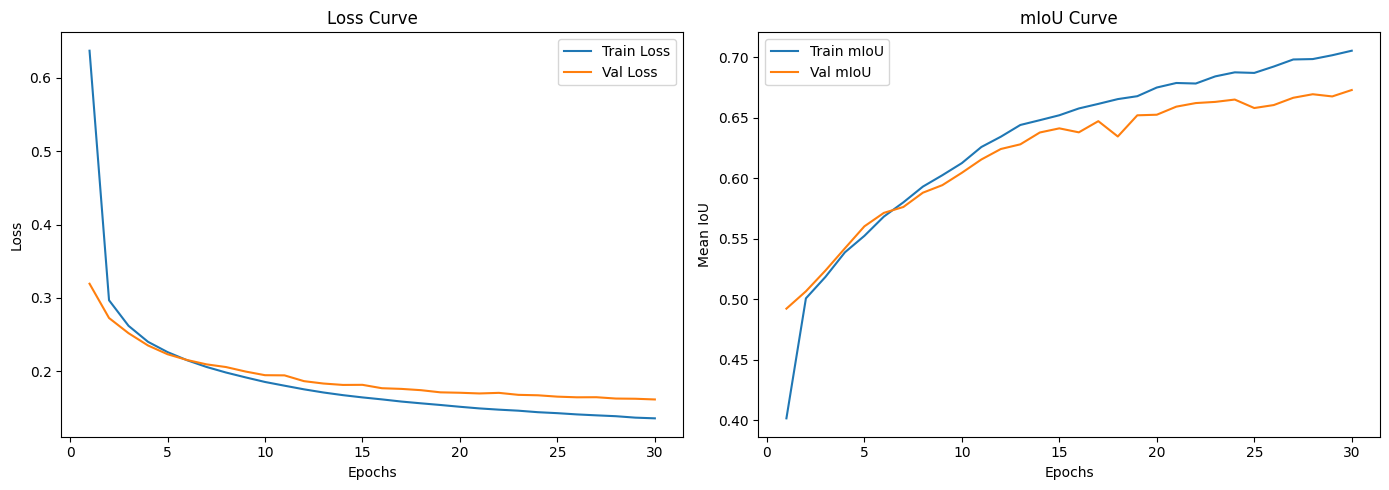

In [19]:
# Example usage (replace FCN32s with FCN16s or FCN8s later):
model1 = FCN32s()
train_loss, val_loss, train_miou, val_miou = train_model(model1,  train_loader, val_loader,tag="FCN32s", num_epochs=30)
plot_metrics(train_loss, val_loss, train_miou, val_miou)


[Epoch 1/30] Train Loss: 0.7193, mIoU: 0.3193 | Val Loss: 0.3039, mIoU: 0.4945
[Epoch 2/30] Train Loss: 0.2754, mIoU: 0.5075 | Val Loss: 0.2498, mIoU: 0.5211
[Epoch 3/30] Train Loss: 0.2358, mIoU: 0.5321 | Val Loss: 0.2228, mIoU: 0.5445
[Epoch 4/30] Train Loss: 0.2129, mIoU: 0.5534 | Val Loss: 0.2079, mIoU: 0.5595
[Epoch 5/30] Train Loss: 0.1976, mIoU: 0.5696 | Val Loss: 0.1971, mIoU: 0.5740
[Epoch 6/30] Train Loss: 0.1867, mIoU: 0.5851 | Val Loss: 0.1904, mIoU: 0.5914
[Epoch 7/30] Train Loss: 0.1785, mIoU: 0.6048 | Val Loss: 0.1818, mIoU: 0.6001
[Epoch 8/30] Train Loss: 0.1720, mIoU: 0.6205 | Val Loss: 0.1782, mIoU: 0.6131
[Epoch 9/30] Train Loss: 0.1665, mIoU: 0.6301 | Val Loss: 0.1739, mIoU: 0.6234
[Epoch 10/30] Train Loss: 0.1622, mIoU: 0.6396 | Val Loss: 0.1728, mIoU: 0.6374
[Epoch 11/30] Train Loss: 0.1588, mIoU: 0.6461 | Val Loss: 0.1685, mIoU: 0.6363
[Epoch 12/30] Train Loss: 0.1552, mIoU: 0.6557 | Val Loss: 0.1663, mIoU: 0.6444
[Epoch 13/30] Train Loss: 0.1524, mIoU: 0.6608 | 

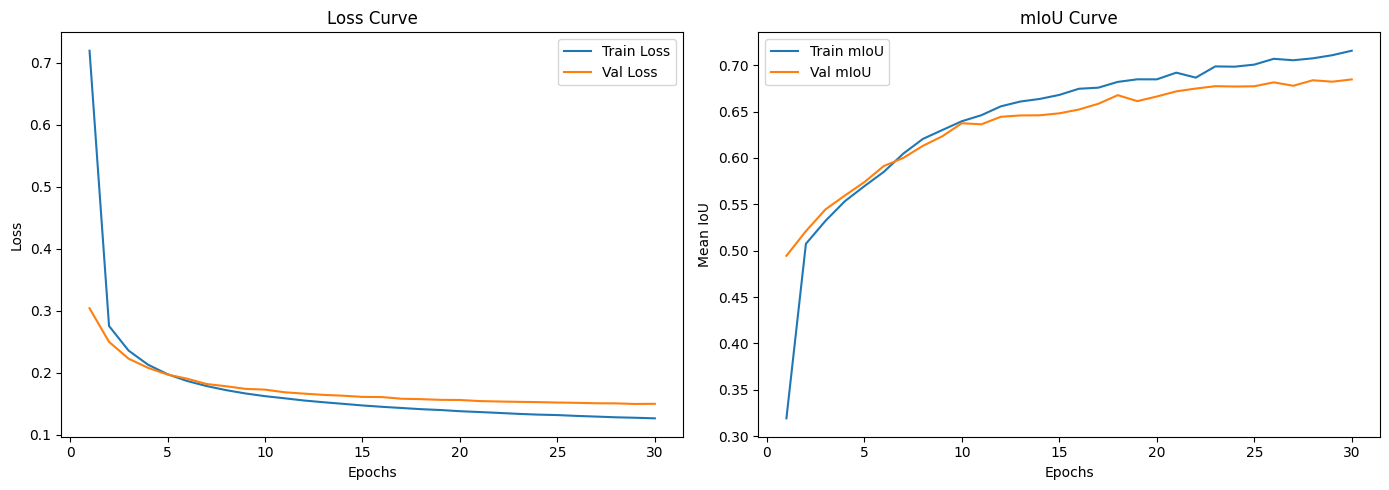

In [20]:
# Example usage (replace FCN32s with FCN16s or FCN8s later):
model2 = FCN16s()
train_loss, val_loss, train_miou, val_miou = train_model(model2, train_loader, val_loader,tag="FCN16s", num_epochs=30)
plot_metrics(train_loss, val_loss, train_miou, val_miou)


[Epoch 1/30] Train Loss: 0.8674, mIoU: 0.2206 | Val Loss: 0.3012, mIoU: 0.4989
[Epoch 2/30] Train Loss: 0.2658, mIoU: 0.5157 | Val Loss: 0.2410, mIoU: 0.5271
[Epoch 3/30] Train Loss: 0.2216, mIoU: 0.5408 | Val Loss: 0.2086, mIoU: 0.5538
[Epoch 4/30] Train Loss: 0.1981, mIoU: 0.5625 | Val Loss: 0.1917, mIoU: 0.5690
[Epoch 5/30] Train Loss: 0.1824, mIoU: 0.5832 | Val Loss: 0.1811, mIoU: 0.5902
[Epoch 6/30] Train Loss: 0.1713, mIoU: 0.6030 | Val Loss: 0.1727, mIoU: 0.6007
[Epoch 7/30] Train Loss: 0.1635, mIoU: 0.6193 | Val Loss: 0.1669, mIoU: 0.6130
[Epoch 8/30] Train Loss: 0.1568, mIoU: 0.6310 | Val Loss: 0.1614, mIoU: 0.6229
[Epoch 9/30] Train Loss: 0.1514, mIoU: 0.6399 | Val Loss: 0.1570, mIoU: 0.6301
[Epoch 10/30] Train Loss: 0.1470, mIoU: 0.6479 | Val Loss: 0.1536, mIoU: 0.6386
[Epoch 11/30] Train Loss: 0.1428, mIoU: 0.6559 | Val Loss: 0.1508, mIoU: 0.6483
[Epoch 12/30] Train Loss: 0.1402, mIoU: 0.6622 | Val Loss: 0.1479, mIoU: 0.6501
[Epoch 13/30] Train Loss: 0.1370, mIoU: 0.6675 | 

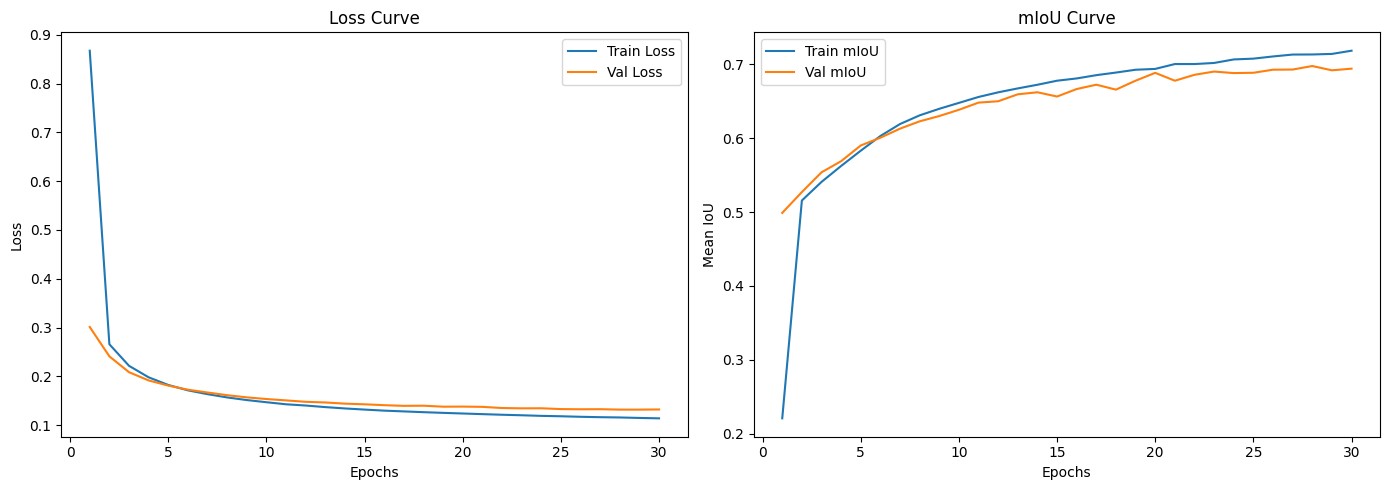

In [21]:
# Example usage (replace FCN32s with FCN16s or FCN8s later):
model3 = FCN8s()
train_loss, val_loss, train_miou, val_miou = train_model(model3, train_loader, val_loader,tag="FCN8s", num_epochs=30)
plot_metrics(train_loss, val_loss, train_miou, val_miou)


In [5]:
def evaluate_model(model, test_loader):
    model.eval()
    model.to(device)
    metric = MulticlassJaccardIndex(num_classes=NUM_CLASSES).to(device)

    total_iou = 0
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)
            preds = torch.argmax(outputs, dim=1)
            total_iou += metric(preds, masks).item()

    mean_iou = total_iou / len(test_loader)
    print(f"Test mIoU: {mean_iou:.4f}")
    return mean_iou

def visualize_predictions(model, test_loader, num_samples=3):
    model.eval()
    model.to(device)

    # Generate a color map for 13 classes
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm

    colormap = cm.get_cmap('tab20', NUM_CLASSES)

    shown = 0
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            outputs = model(images)
            outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)
            preds = torch.argmax(outputs, dim=1).cpu()

            # Move everything to CPU
            image = images[0].cpu().permute(1, 2, 0).numpy()
            image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Unnormalize
            image = np.clip(image, 0, 1)

            gt_mask = masks[0].cpu().numpy()
            pred_mask = preds[0].numpy()

            # Plot
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(image)
            axes[0].set_title("Input Image")
            axes[1].imshow(gt_mask, cmap=colormap, norm=mcolors.Normalize(vmin=0, vmax=NUM_CLASSES - 1))
            axes[1].set_title("Ground Truth")
            axes[2].imshow(pred_mask, cmap=colormap, norm=mcolors.Normalize(vmin=0, vmax=NUM_CLASSES - 1))
            axes[2].set_title("Predicted Mask")
            for ax in axes:
                ax.axis('off')
            plt.tight_layout()
            plt.show()

            shown += 1
            if shown >= num_samples:
                break


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 188MB/s]  
<ipython-input-6-b744f06cde93>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to constr

Test mIoU: 0.6473


<ipython-input-5-9b7e6eba3c91>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20', NUM_CLASSES)


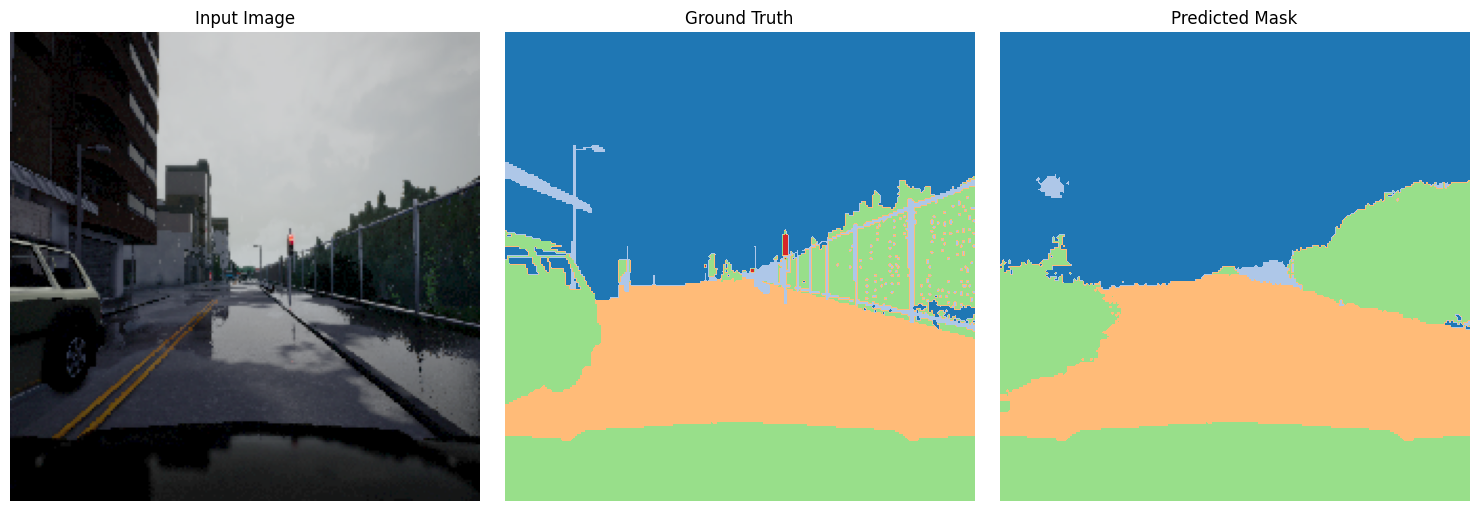

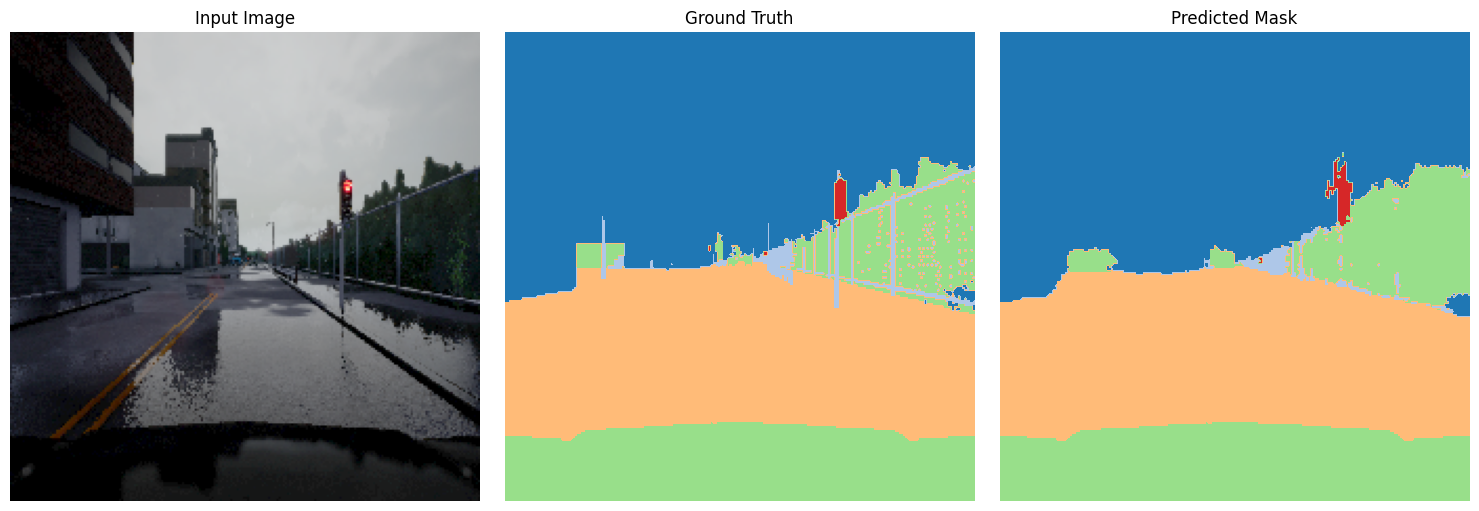

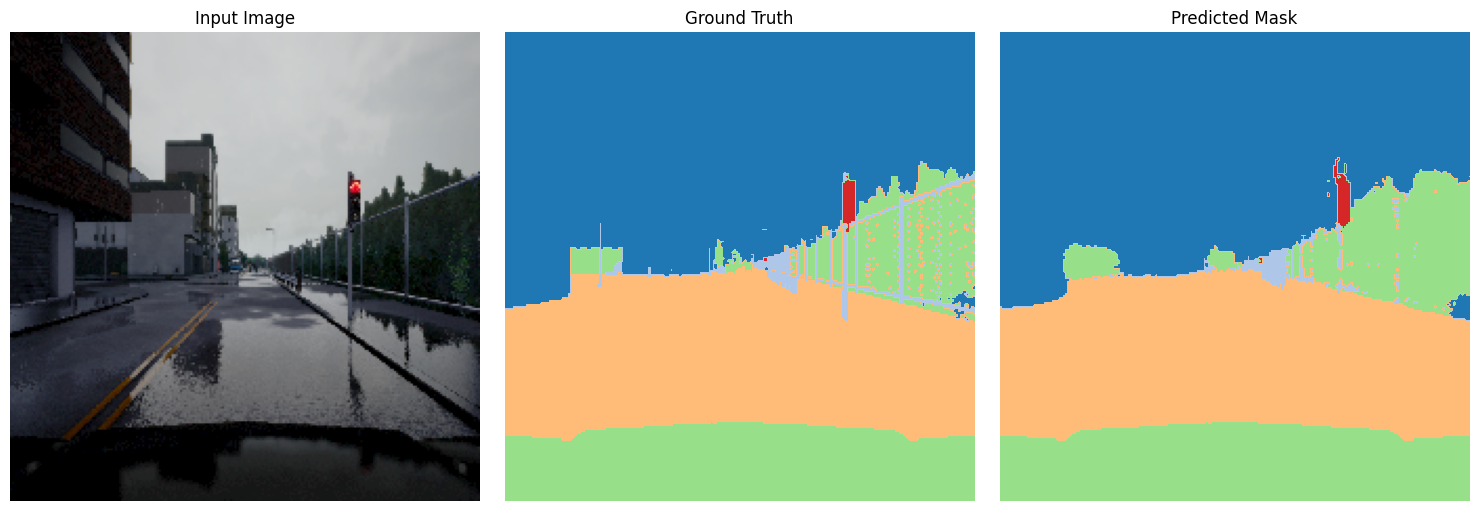

In [6]:
# FCN-32s
model_32s = FCN32s()
model_32s.load_state_dict(torch.load('FCN32s.pth'))  # after saving from training
evaluate_model(model_32s, test_loader)
visualize_predictions(model_32s, test_loader)

<ipython-input-7-fbe8ea43c244>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_16s.load_state_dict(torch.load('FCN16s.pth'))


Test mIoU: 0.6523


<ipython-input-5-9b7e6eba3c91>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20', NUM_CLASSES)


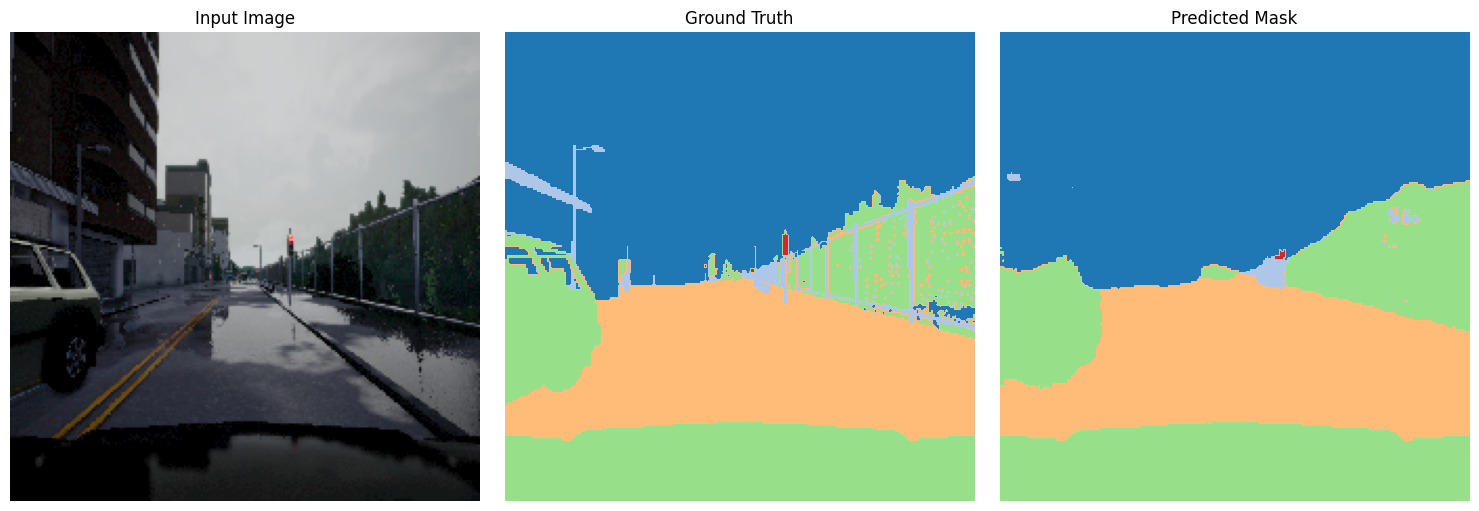

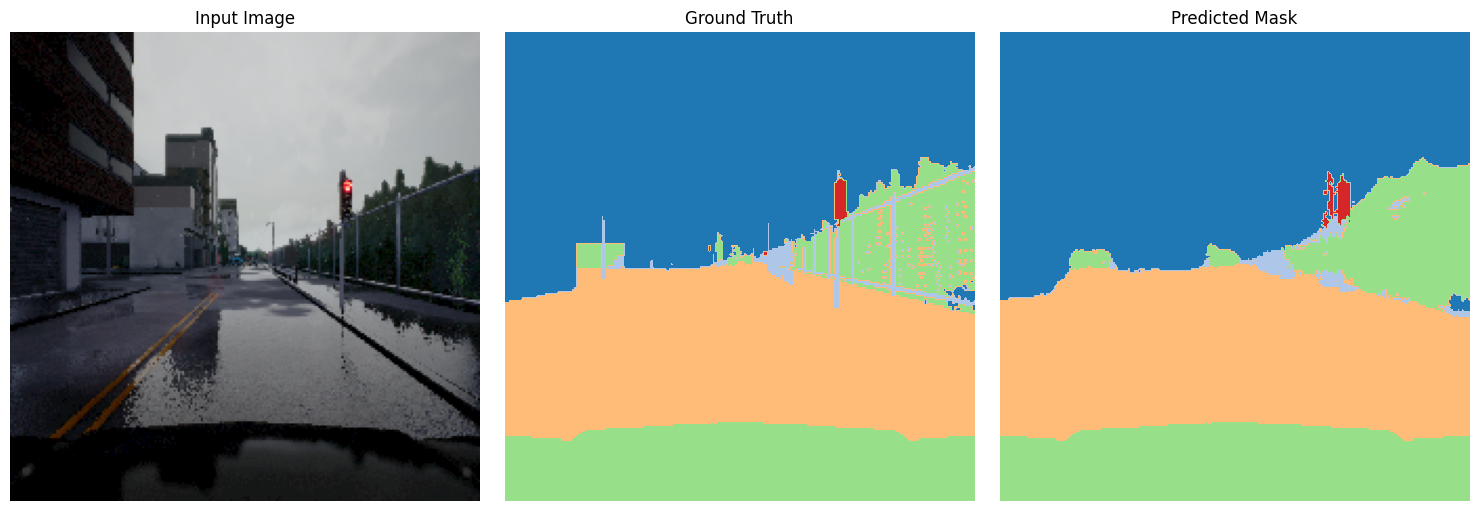

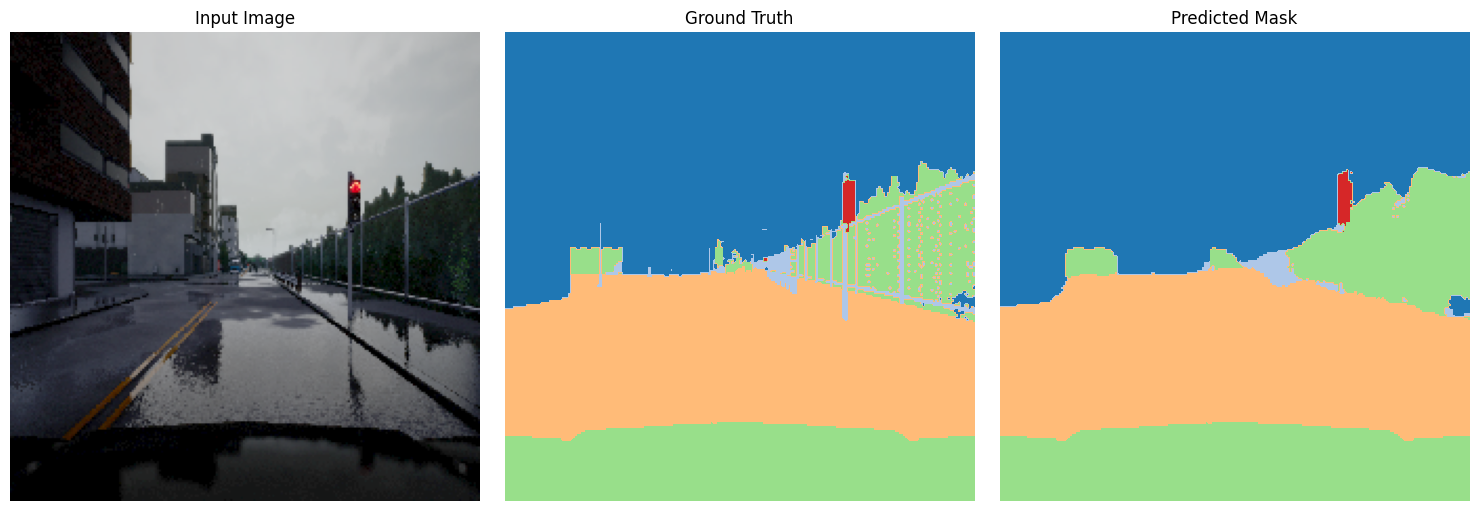

In [7]:
# FCN-16s
model_16s = FCN16s()
model_16s.load_state_dict(torch.load('FCN16s.pth'))
evaluate_model(model_16s, test_loader)
visualize_predictions(model_16s, test_loader)

<ipython-input-8-33907915ed5b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_8s.load_state_dict(torch.load('FCN8s.pth'))


Test mIoU: 0.6645


<ipython-input-5-9b7e6eba3c91>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20', NUM_CLASSES)


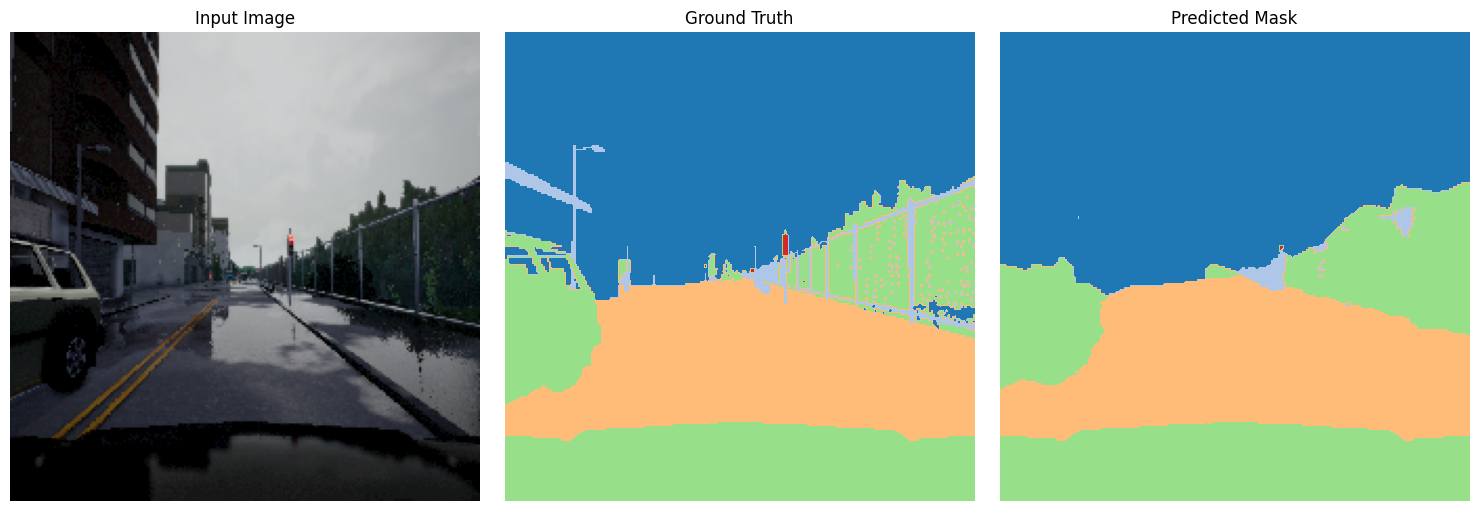

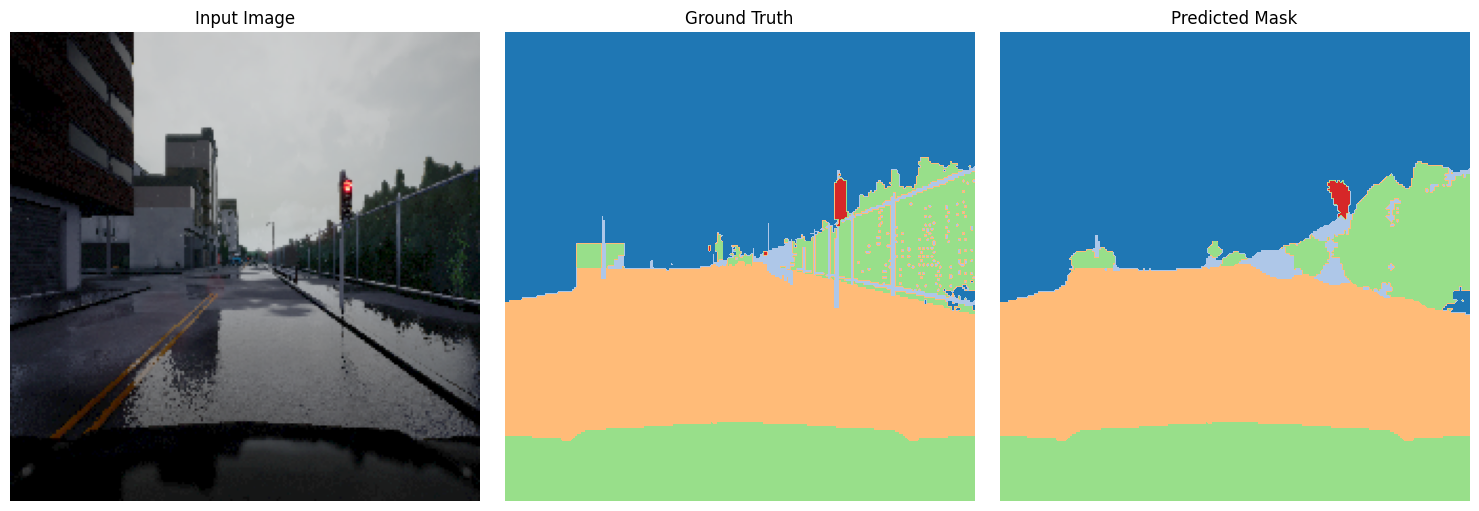

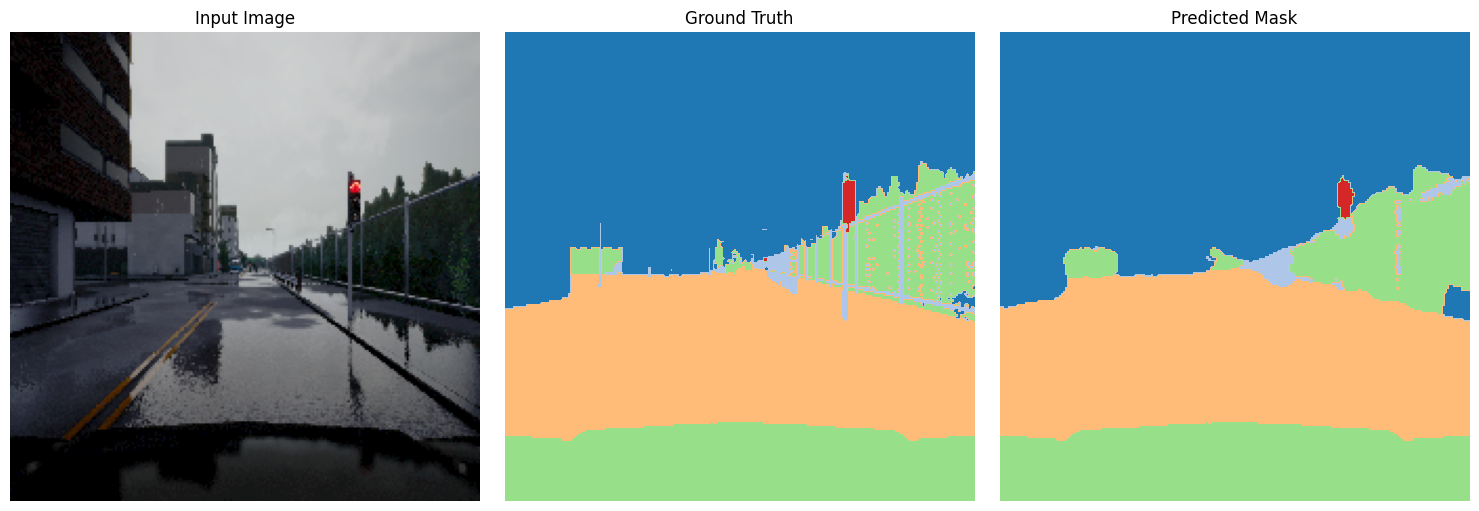

In [8]:
# FCN-8s
model_8s = FCN8s()
model_8s.load_state_dict(torch.load('FCN8s.pth'))
evaluate_model(model_8s, test_loader)
visualize_predictions(model_8s, test_loader)